In [331]:
import pandas as pd
import numpy as np
from datetime import datetime
from binance.futures import Futures as Client
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from backtest import BacktestLongShort_learnable_SMA as BKL
from scipy.stats import shapiro
from scipy import stats, signal
from random import choices
from scipy.stats import kstest, norm
import ta
from sklearn.metrics import accuracy_score
%matplotlib inline

In [50]:
from BTC import get_new_data, get_hist_data, indi_calc, strategy_calc

In [22]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df_5min = pd.read_csv('5m_010122_082322.csv')
df_5min.index = df_5min['Open time']
df_5min = df_5min.drop('Open time', axis = 1)

# 5 min
# lag=5

In [3]:
data = pd.DataFrame(df_5min['Close'])
data.rename(columns={'Close': 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)

In [7]:
lags = 5
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [9]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)
data.dropna(inplace=True)

In [13]:
cols.extend(['momentum', 'volatility', 'distance'])

In [14]:
print(data.round(4).tail())

                       price  return  direction   lag_1   lag_2   lag_3  \
Open time                                                                 
2022-08-25 00:40:00  21519.0 -0.0006          0 -0.0009  0.0018  0.0006   
2022-08-25 00:45:00  21528.9  0.0005          1 -0.0006 -0.0009  0.0018   
2022-08-25 00:50:00  21512.8 -0.0007          0  0.0005 -0.0006 -0.0009   
2022-08-25 00:55:00  21528.9  0.0007          1 -0.0007  0.0005 -0.0006   
2022-08-25 01:00:00  21544.1  0.0007          1  0.0007 -0.0007  0.0005   

                      lag_4   lag_5  momentum  volatility  distance  
Open time                                                            
2022-08-25 00:40:00 -0.0007 -0.0002    0.0001      0.0014    20.206  
2022-08-25 00:45:00  0.0006 -0.0007    0.0000      0.0014     6.064  
2022-08-25 00:50:00  0.0018  0.0006    0.0003      0.0013    13.980  
2022-08-25 00:55:00 -0.0009  0.0018    0.0000      0.0013    -3.514  
2022-08-25 01:00:00 -0.0006 -0.0009   -0.0002      0.0

In [15]:
cutoff = '2022-05-01 01:00:00'

In [16]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

In [24]:
optimizer = Adam(learning_rate=0.0001)

In [25]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [27]:
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 1min 41s


In [29]:
model.evaluate(training_data_[cols], training_data['direction'])

1079/1079 [==============================] - 3s 2ms/step - loss: 0.6863 - accuracy: 0.5482


[0.6862908005714417, 0.5481683015823364]

In [30]:
pred = model.predict(training_data_[cols])

In [31]:
training_data['prediction'] = np.where(pred > 0.5, 1, -1)

In [32]:
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']

In [33]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return       0.807312
strategy    20.449731
dtype: float64

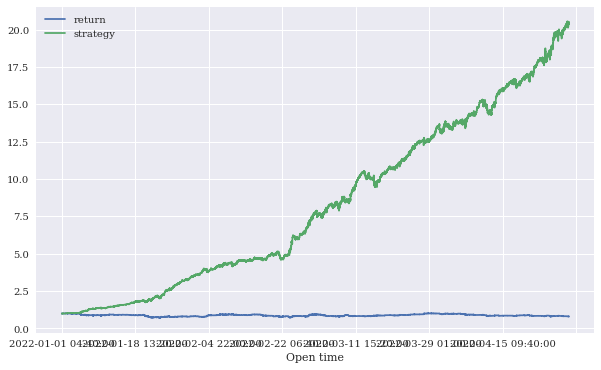

In [34]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

In [35]:
model.evaluate(test_data_[cols], test_data['direction'])

1045/1045 [==============================] - 3s 3ms/step - loss: 0.6923 - accuracy: 0.5256


[0.6923373341560364, 0.5256367921829224]

In [36]:
pred = model.predict(test_data_[cols])

In [37]:
test_data['prediction'] = np.where(pred > 0.5, 1, -1)

In [38]:
test_data['prediction'].value_counts()

 1    18164
-1    15245
Name: prediction, dtype: int64

In [39]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [40]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.567996
strategy    1.900731
dtype: float64

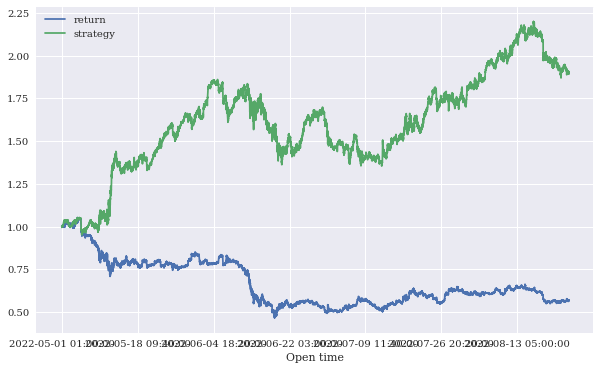

In [41]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

# lag=5, RSI

## data

In [73]:
rsi = ta.momentum.RSIIndicator(df_5min['Open'], 14, False)
#adx = ta.trend.ADXIndicator(self.df['High'], self.df['Low'], self.df['Close'] , ADX_window, False)

In [89]:
data = pd.DataFrame(df_5min['Close'])
data.rename(columns={'Close': 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
data['rsi'] = rsi.rsi()

In [90]:
lags = 5
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [91]:
cols.extend(['rsi'])

In [92]:
print(data.round(4).tail())

                       price  return  direction      rsi   lag_1   lag_2  \
Open time                                                                  
2022-08-25 00:40:00  21519.0 -0.0006          0  54.7645 -0.0009  0.0018   
2022-08-25 00:45:00  21528.9  0.0005          1  52.2320 -0.0006 -0.0009   
2022-08-25 00:50:00  21512.8 -0.0007          0  54.1055  0.0005 -0.0006   
2022-08-25 00:55:00  21528.9  0.0007          1  50.6605 -0.0007  0.0005   
2022-08-25 01:00:00  21544.1  0.0007          1  53.8082  0.0007 -0.0007   

                      lag_3   lag_4   lag_5  
Open time                                    
2022-08-25 00:40:00  0.0006 -0.0007 -0.0002  
2022-08-25 00:45:00  0.0018  0.0006 -0.0007  
2022-08-25 00:50:00 -0.0009  0.0018  0.0006  
2022-08-25 00:55:00 -0.0006 -0.0009  0.0018  
2022-08-25 01:00:00  0.0005 -0.0006 -0.0009  


In [93]:
cutoff = '2022-05-01 01:00:00'

In [94]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

## model

In [95]:
optimizer = Adam(learning_rate=0.0001)

In [96]:
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [97]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 1min 38s


In [98]:
model.evaluate(training_data_[cols], training_data['direction'])

1080/1080 [==============================] - 3s 3ms/step - loss: 0.6874 - accuracy: 0.5433


[0.6874345541000366, 0.5432888269424438]

In [99]:
pred = model.predict(training_data_[cols])
training_data['prediction'] = np.where(pred > 0.5, 1, -1)
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']
training_data[['return', 'strategy']].sum().apply(np.exp)


return      0.805318
strategy    8.963923
dtype: float64

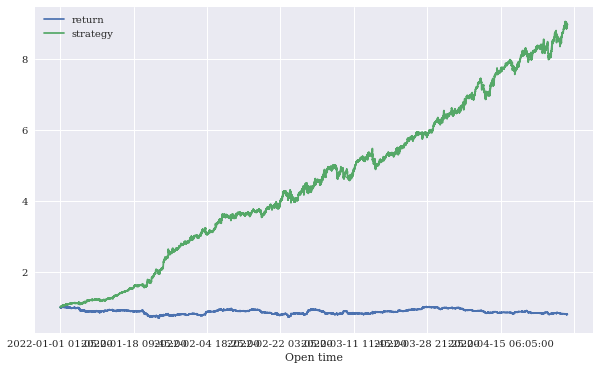

In [100]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

## test

In [101]:
model.evaluate(test_data_[cols], test_data['direction'])

1045/1045 [==============================] - 3s 3ms/step - loss: 0.6926 - accuracy: 0.5241


[0.6925910115242004, 0.5241401791572571]

In [102]:
pred = model.predict(test_data_[cols])
test_data['prediction'] = np.where(pred > 0.5, 1, -1)
test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.567996
strategy    2.385734
dtype: float64

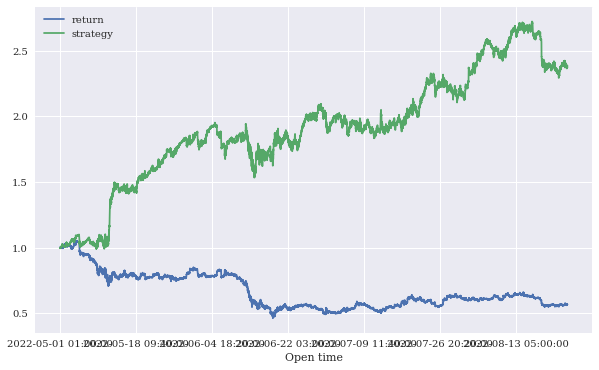

In [103]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

# lag=5, RSI, ADX

## data

In [106]:
rsi = ta.momentum.RSIIndicator(df_5min['Open'], 14, False)
adx = ta.trend.ADXIndicator(df_5min['High'], df_5min['Low'], df_5min['Close'] , 20, False)

In [107]:
data = pd.DataFrame(df_5min['Close'])
data.rename(columns={'Close': 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
data['rsi'] = rsi.rsi()

data['adx'] = adx.adx()
data['adx_neg'] = adx.adx_neg()
data['adx_pos'] = adx.adx_pos()

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [109]:
data[['adx', 'adx_neg', 'adx_pos']] = data[['adx', 'adx_neg', 'adx_pos']].shift(1)

In [111]:
lags = 5
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [112]:
cols.extend(['rsi', 'adx', 'adx_neg', 'adx_pos'])

In [113]:
print(data.round(4).tail())

                       price  return  direction      rsi      adx  adx_neg  \
Open time                                                                    
2022-08-25 00:40:00  21519.0 -0.0006          0  54.7645  14.8480  19.6171   
2022-08-25 00:45:00  21528.9  0.0005          1  52.2320  14.1616  20.8574   
2022-08-25 00:50:00  21512.8 -0.0007          0  54.1055  13.5830  20.9549   
2022-08-25 00:55:00  21528.9  0.0007          1  50.6605  13.1792  21.3966   
2022-08-25 01:00:00  21544.1  0.0007          1  53.8082  12.7956  20.8630   

                     adx_pos   lag_1   lag_2   lag_3   lag_4   lag_5  
Open time                                                             
2022-08-25 00:40:00  21.1066 -0.0009  0.0018  0.0006 -0.0007 -0.0002  
2022-08-25 00:45:00  20.3950 -0.0006 -0.0009  0.0018  0.0006 -0.0007  
2022-08-25 00:50:00  19.8972  0.0005 -0.0006 -0.0009  0.0018  0.0006  
2022-08-25 00:55:00  19.1630 -0.0007  0.0005 -0.0006 -0.0009  0.0018  
2022-08-25 01:00:00  18.685

In [114]:
cutoff = '2022-05-01 01:00:00'

In [115]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

## model

In [116]:
optimizer = Adam(learning_rate=0.0001)

In [117]:
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [118]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 1min 40s


In [119]:
model.evaluate(training_data_[cols], training_data['direction'])

1080/1080 [==============================] - 3s 3ms/step - loss: 0.6860 - accuracy: 0.5489


[0.685981810092926, 0.5489044189453125]

In [120]:
pred = model.predict(training_data_[cols])
training_data['prediction'] = np.where(pred > 0.5, 1, -1)
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']
training_data[['return', 'strategy']].sum().apply(np.exp)


return       0.805318
strategy    26.166613
dtype: float64

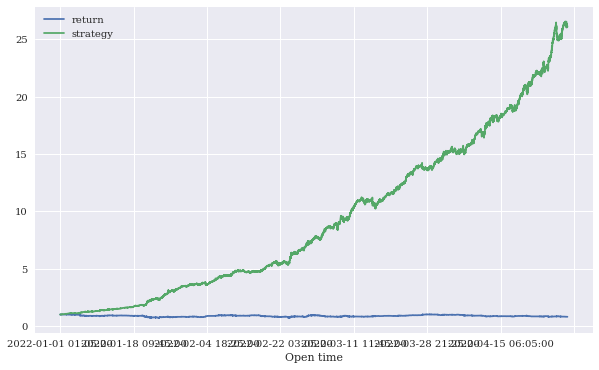

In [121]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

## test

In [122]:
model.evaluate(test_data_[cols], test_data['direction'])

1045/1045 [==============================] - 3s 3ms/step - loss: 0.6926 - accuracy: 0.5245


[0.6926482319831848, 0.5245293378829956]

In [123]:
pred = model.predict(test_data_[cols])
test_data['prediction'] = np.where(pred > 0.5, 1, -1)
test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.567996
strategy    2.489743
dtype: float64

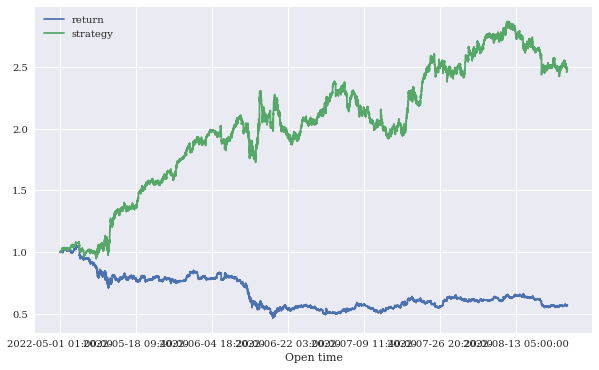

In [124]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

# lag=10, RSI, ADX

## data

In [304]:
rsi = ta.momentum.RSIIndicator(df_5min['Open'], 14, False)
adx = ta.trend.ADXIndicator(df_5min['High'], df_5min['Low'], df_5min['Close'] , 20, False)

In [305]:
data = pd.DataFrame(df_5min['Close'])
data.rename(columns={'Close': 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
data['rsi'] = rsi.rsi()

data['adx'] = adx.adx()
data['adx_neg'] = adx.adx_neg()
data['adx_pos'] = adx.adx_pos()

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [306]:
data[['adx', 'adx_neg', 'adx_pos']] = data[['adx', 'adx_neg', 'adx_pos']].shift(1)

In [307]:
lags = 10
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [308]:
cols.extend(['rsi', 'adx', 'adx_neg', 'adx_pos'])

In [309]:
print(data.round(4).tail())

                       price  return  direction      rsi      adx  adx_neg  \
Open time                                                                    
2022-08-25 00:40:00  21519.0 -0.0006          0  54.7645  14.8480  19.6171   
2022-08-25 00:45:00  21528.9  0.0005          1  52.2320  14.1616  20.8574   
2022-08-25 00:50:00  21512.8 -0.0007          0  54.1055  13.5830  20.9549   
2022-08-25 00:55:00  21528.9  0.0007          1  50.6605  13.1792  21.3966   
2022-08-25 01:00:00  21544.1  0.0007          1  53.8082  12.7956  20.8630   

                     adx_pos   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6  \
Open time                                                                      
2022-08-25 00:40:00  21.1066 -0.0009  0.0018  0.0006 -0.0007 -0.0002  0.0012   
2022-08-25 00:45:00  20.3950 -0.0006 -0.0009  0.0018  0.0006 -0.0007 -0.0002   
2022-08-25 00:50:00  19.8972  0.0005 -0.0006 -0.0009  0.0018  0.0006 -0.0007   
2022-08-25 00:55:00  19.1630 -0.0007  0.0005 -0.0006 

In [310]:
cutoff = '2022-05-01 01:00:00'

In [311]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

## model

In [312]:
optimizer = Adam(learning_rate=0.0001)

In [313]:
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [314]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 1min 36s


In [315]:
model.evaluate(training_data_[cols], training_data['direction'])

1080/1080 [==============================] - 3s 3ms/step - loss: 0.6841 - accuracy: 0.5548


[0.6841227412223816, 0.5548093914985657]

In [316]:
pred = model.predict(training_data_[cols])
training_data['prediction'] = np.where(pred > 0.5, 1, -1)
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']
training_data[['return', 'strategy']].sum().apply(np.exp)


return       0.805318
strategy    55.928425
dtype: float64

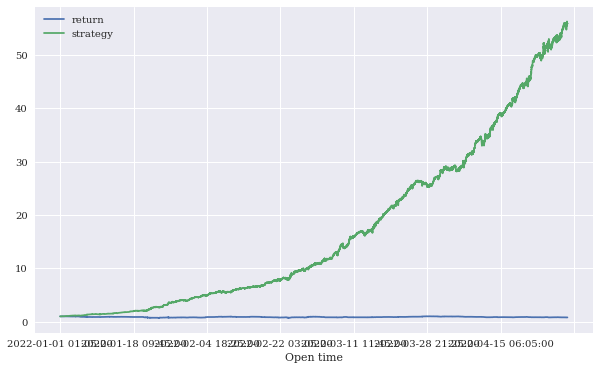

In [317]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

## test

In [318]:
model.evaluate(test_data_[cols], test_data['direction'])

1045/1045 [==============================] - 3s 3ms/step - loss: 0.6937 - accuracy: 0.5253


[0.693677544593811, 0.5253374576568604]

In [319]:
pred = model.predict(test_data_[cols])
test_data['prediction'] = np.where(pred > 0.5, 1, -1)
test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.567996
strategy    2.812959
dtype: float64

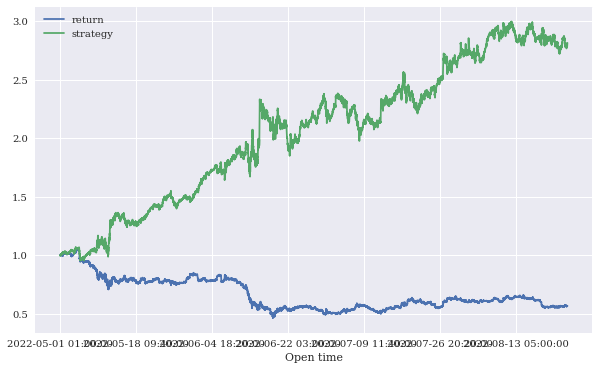

In [320]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

### Analysis of results

In [323]:
test_df = test_data[['return', 'prediction', 'direction']]

In [324]:
test_df['prediction'] = pred

<ipython-input-324-edfa8d531a93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = pred


In [376]:
limit = 0.05

In [377]:
limit_long = 0.5 + limit
limit_short = 0.5 - limit
test_df['perd_position'] = test_df.prediction.apply(lambda x : 1 if x > limit_long else (-1 if x < limit_short else 0))
tdf = test_df.loc[test_df['perd_position'] != 0]
tdf.perd_position.replace(-1, 0,inplace=True)
print('number of rows:', len(tdf))
y_pred = tdf.perd_position
y_true = tdf.direction
accuracy_score(y_true, y_pred)

number of rows: 12113


<ipython-input-377-fd9042a530c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['perd_position'] = test_df.prediction.apply(lambda x : 1 if x > limit_long else (-1 if x < limit_short else 0))
C:\Users\bakhi\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


0.5390076777016428

In [378]:
pred = model.predict(test_data_[cols])
test_data['pred'] = pred
#test_data['prediction'] = np.where(pred > 0.5, 1, -1)
limit_long = 0.5 + limit
limit_short = 0.5 - limit
test_data['prediction'] = test_data.pred.apply(lambda x : 1 if x > limit_long else (-1 if x < limit_short else 0))

test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.567996
strategy    2.103457
dtype: float64

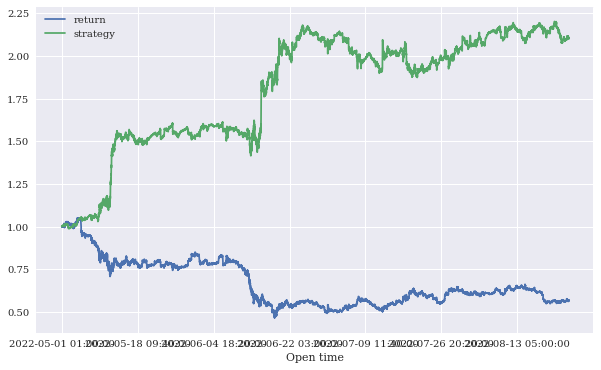

In [379]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

# lag=10, RSI, ADX, cutoff = 07_2022

## data

In [380]:
rsi = ta.momentum.RSIIndicator(df_5min['Open'], 14, False)
adx = ta.trend.ADXIndicator(df_5min['High'], df_5min['Low'], df_5min['Close'] , 20, False)

In [381]:
data = pd.DataFrame(df_5min['Close'])
data.rename(columns={'Close': 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
data['rsi'] = rsi.rsi()

data['adx'] = adx.adx()
data['adx_neg'] = adx.adx_neg()
data['adx_pos'] = adx.adx_pos()

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [382]:
data[['adx', 'adx_neg', 'adx_pos']] = data[['adx', 'adx_neg', 'adx_pos']].shift(1)

In [383]:
lags = 10
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [384]:
cols.extend(['rsi', 'adx', 'adx_neg', 'adx_pos'])

In [385]:
print(data.round(4).tail())

                       price  return  direction      rsi      adx  adx_neg  \
Open time                                                                    
2022-08-25 00:40:00  21519.0 -0.0006          0  54.7645  14.8480  19.6171   
2022-08-25 00:45:00  21528.9  0.0005          1  52.2320  14.1616  20.8574   
2022-08-25 00:50:00  21512.8 -0.0007          0  54.1055  13.5830  20.9549   
2022-08-25 00:55:00  21528.9  0.0007          1  50.6605  13.1792  21.3966   
2022-08-25 01:00:00  21544.1  0.0007          1  53.8082  12.7956  20.8630   

                     adx_pos   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6  \
Open time                                                                      
2022-08-25 00:40:00  21.1066 -0.0009  0.0018  0.0006 -0.0007 -0.0002  0.0012   
2022-08-25 00:45:00  20.3950 -0.0006 -0.0009  0.0018  0.0006 -0.0007 -0.0002   
2022-08-25 00:50:00  19.8972  0.0005 -0.0006 -0.0009  0.0018  0.0006 -0.0007   
2022-08-25 00:55:00  19.1630 -0.0007  0.0005 -0.0006 

In [386]:
cutoff = '2022-07-01 01:00:00'

In [387]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

## model

In [388]:
optimizer = Adam(learning_rate=0.0001)

In [389]:
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [390]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 2min 22s


In [391]:
model.evaluate(training_data_[cols], training_data['direction'])

1629/1629 [==============================] - 4s 3ms/step - loss: 0.6850 - accuracy: 0.5514


[0.6850426197052002, 0.5513767600059509]

In [392]:
pred = model.predict(training_data_[cols])
training_data['prediction'] = np.where(pred > 0.5, 1, -1)
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']
training_data[['return', 'strategy']].sum().apply(np.exp)


return        0.411888
strategy    755.826500
dtype: float64

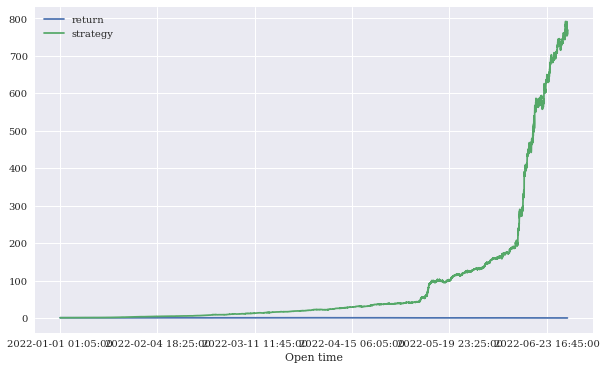

In [393]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

## test

In [394]:
model.evaluate(test_data_[cols], test_data['direction'])

496/496 [==============================] - 1s 3ms/step - loss: 0.6918 - accuracy: 0.5282


[0.6918433904647827, 0.5282495021820068]

In [395]:
pred = model.predict(test_data_[cols])
test_data['prediction'] = np.where(pred > 0.5, 1, -1)
test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      1.110538
strategy    1.468410
dtype: float64

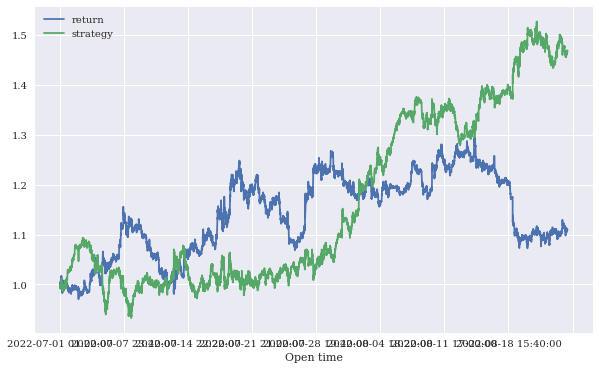

In [396]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

### Analysis of results

In [397]:
test_df = test_data[['return', 'prediction', 'direction']]

In [398]:
test_df['prediction'] = pred

<ipython-input-398-edfa8d531a93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = pred


In [401]:
limit = 0.05

In [402]:
limit_long = 0.5 + limit
limit_short = 0.5 - limit
test_df['perd_position'] = test_df.prediction.apply(lambda x : 1 if x > limit_long else (-1 if x < limit_short else 0))
tdf = test_df.loc[test_df['perd_position'] != 0]
tdf.perd_position.replace(-1, 0,inplace=True)
print('number of rows:', len(tdf))
y_pred = tdf.perd_position
y_true = tdf.direction
accuracy_score(y_true, y_pred)

number of rows: 4622


<ipython-input-402-fd9042a530c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['perd_position'] = test_df.prediction.apply(lambda x : 1 if x > limit_long else (-1 if x < limit_short else 0))
C:\Users\bakhi\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


0.5445694504543488

In [403]:
pred = model.predict(test_data_[cols])
test_data['pred'] = pred
#test_data['prediction'] = np.where(pred > 0.5, 1, -1)
limit_long = 0.5 + limit
limit_short = 0.5 - limit
test_data['prediction'] = test_data.pred.apply(lambda x : 1 if x > limit_long else (-1 if x < limit_short else 0))

test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      1.110538
strategy    1.241043
dtype: float64

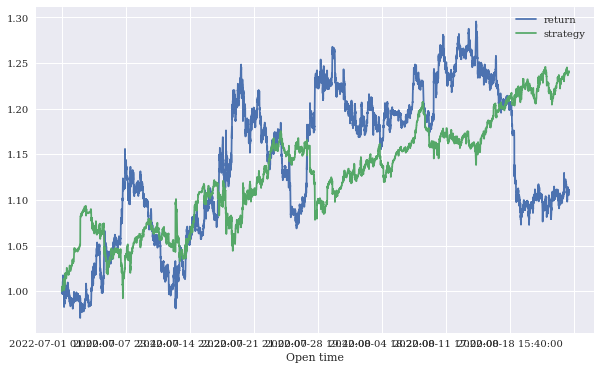

In [404]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

# lag=10, RSI, ADX, RSI_GAP, RSI_MA

## data

In [405]:
rsi = ta.momentum.RSIIndicator(df_5min['Open'], 14, False)
adx = ta.trend.ADXIndicator(df_5min['High'], df_5min['Low'], df_5min['Close'] , 20, False)

In [406]:
data = pd.DataFrame(df_5min['Close'])
data.rename(columns={'Close': 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
data['rsi'] = rsi.rsi()

data['adx'] = adx.adx()
data['adx_neg'] = adx.adx_neg()
data['adx_pos'] = adx.adx_pos()

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [407]:
data['rsi_MA'] = data['rsi'].rolling(3).mean()
data['rsi_MA_dist'] = data['rsi']-data['rsi_MA']

In [408]:
data[['adx', 'adx_neg', 'adx_pos']] = data[['adx', 'adx_neg', 'adx_pos']].shift(1)

In [409]:
lags = 10
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [410]:
cols.extend(['rsi', 'adx', 'adx_neg', 'adx_pos', 'rsi_MA', 'rsi_MA_dist'])

In [411]:
print(data.round(4).tail())

                       price  return  direction      rsi      adx  adx_neg  \
Open time                                                                    
2022-08-25 00:40:00  21519.0 -0.0006          0  54.7645  14.8480  19.6171   
2022-08-25 00:45:00  21528.9  0.0005          1  52.2320  14.1616  20.8574   
2022-08-25 00:50:00  21512.8 -0.0007          0  54.1055  13.5830  20.9549   
2022-08-25 00:55:00  21528.9  0.0007          1  50.6605  13.1792  21.3966   
2022-08-25 01:00:00  21544.1  0.0007          1  53.8082  12.7956  20.8630   

                     adx_pos   rsi_MA  rsi_MA_dist   lag_1   lag_2   lag_3  \
Open time                                                                    
2022-08-25 00:40:00  21.1066  55.3443      -0.5797 -0.0009  0.0018  0.0006   
2022-08-25 00:45:00  20.3950  55.3829      -3.1509 -0.0006 -0.0009  0.0018   
2022-08-25 00:50:00  19.8972  53.7007       0.4048  0.0005 -0.0006 -0.0009   
2022-08-25 00:55:00  19.1630  52.3327      -1.6721 -0.0007  0.0

In [412]:
cutoff = '2022-05-01 01:00:00'

In [413]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

## model

In [414]:
optimizer = Adam(learning_rate=0.0001)

In [415]:
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [416]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 1min 34s


In [417]:
model.evaluate(training_data_[cols], training_data['direction'])

1080/1080 [==============================] - 3s 3ms/step - loss: 0.6841 - accuracy: 0.5537


[0.6841217279434204, 0.553654670715332]

In [418]:
pred = model.predict(training_data_[cols])
training_data['prediction'] = np.where(pred > 0.5, 1, -1)
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']
training_data[['return', 'strategy']].sum().apply(np.exp)


return       0.802073
strategy    52.692731
dtype: float64

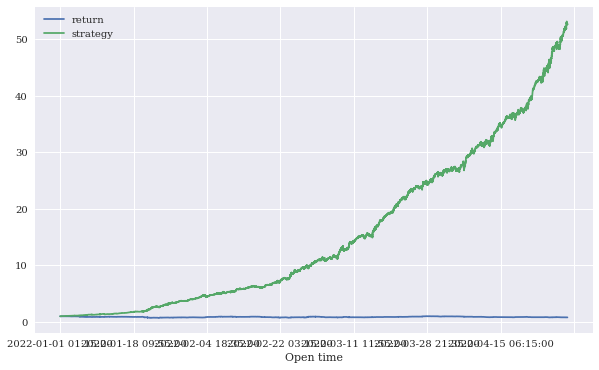

In [419]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

## test

In [420]:
model.evaluate(test_data_[cols], test_data['direction'])

1045/1045 [==============================] - 3s 3ms/step - loss: 0.6940 - accuracy: 0.5205


[0.6940023899078369, 0.5205483436584473]

In [421]:
pred = model.predict(test_data_[cols])
test_data['prediction'] = np.where(pred > 0.5, 1, -1)
test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.567996
strategy    1.870031
dtype: float64

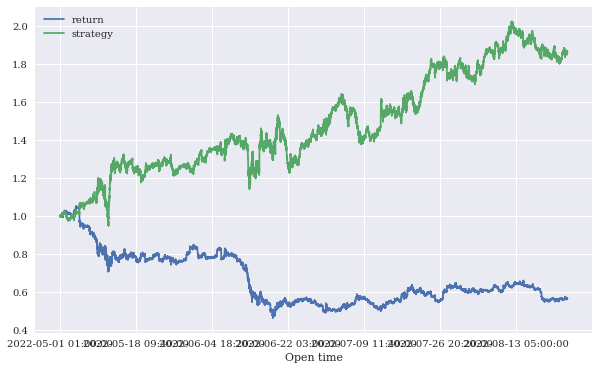

In [422]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

# lag=10, RSI, ADX, VOLUME

## data

In [423]:
rsi = ta.momentum.RSIIndicator(df_5min['Open'], 14, False)
adx = ta.trend.ADXIndicator(df_5min['High'], df_5min['Low'], df_5min['Close'] , 20, False)
volume = df_5min['Volume']

In [424]:
data = pd.DataFrame(df_5min['Close'])
data.rename(columns={'Close': 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
data['rsi'] = rsi.rsi()

data['adx'] = adx.adx()
data['adx_neg'] = adx.adx_neg()
data['adx_pos'] = adx.adx_pos()
data['volume'] = volume

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [425]:
data[['adx', 'adx_neg', 'adx_pos', 'volume']] = data[['adx', 'adx_neg', 'adx_pos', 'volume']].shift(1)

In [426]:
lags = 10
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [427]:
cols.extend(['rsi', 'adx', 'adx_neg', 'adx_pos', 'volume'])

In [428]:
print(data.round(4).tail())

                       price  return  direction      rsi      adx  adx_neg  \
Open time                                                                    
2022-08-25 00:40:00  21519.0 -0.0006          0  54.7645  14.8480  19.6171   
2022-08-25 00:45:00  21528.9  0.0005          1  52.2320  14.1616  20.8574   
2022-08-25 00:50:00  21512.8 -0.0007          0  54.1055  13.5830  20.9549   
2022-08-25 00:55:00  21528.9  0.0007          1  50.6605  13.1792  21.3966   
2022-08-25 01:00:00  21544.1  0.0007          1  53.8082  12.7956  20.8630   

                     adx_pos   volume   lag_1   lag_2   lag_3   lag_4   lag_5  \
Open time                                                                       
2022-08-25 00:40:00  21.1066  722.556 -0.0009  0.0018  0.0006 -0.0007 -0.0002   
2022-08-25 00:45:00  20.3950  365.847 -0.0006 -0.0009  0.0018  0.0006 -0.0007   
2022-08-25 00:50:00  19.8972  310.478  0.0005 -0.0006 -0.0009  0.0018  0.0006   
2022-08-25 00:55:00  19.1630  359.624 -0.0007  0

In [429]:
cutoff = '2022-05-01 01:00:00'

In [430]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

## model

In [431]:
optimizer = Adam(learning_rate=0.0001)

In [432]:
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [433]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 1min 31s


In [434]:
model.evaluate(training_data_[cols], training_data['direction'])

1080/1080 [==============================] - 3s 3ms/step - loss: 0.6838 - accuracy: 0.5548


[0.6838162541389465, 0.5547804236412048]

In [435]:
pred = model.predict(training_data_[cols])
training_data['prediction'] = np.where(pred > 0.5, 1, -1)
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']
training_data[['return', 'strategy']].sum().apply(np.exp)


return       0.805318
strategy    56.524918
dtype: float64

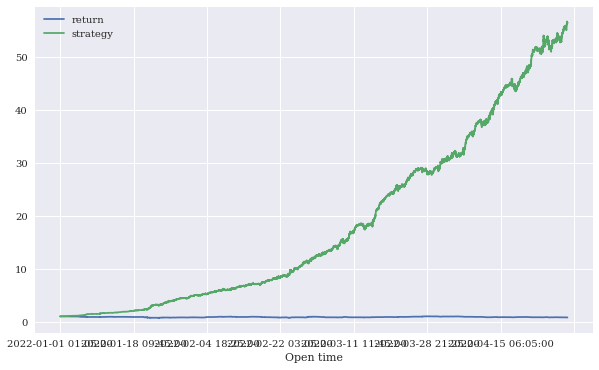

In [436]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

## test

In [437]:
model.evaluate(test_data_[cols], test_data['direction'])

1045/1045 [==============================] - 3s 3ms/step - loss: 0.6941 - accuracy: 0.5223


[0.6940776109695435, 0.522254467010498]

In [438]:
pred = model.predict(test_data_[cols])
test_data['prediction'] = np.where(pred > 0.5, 1, -1)
test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.567996
strategy    1.619237
dtype: float64

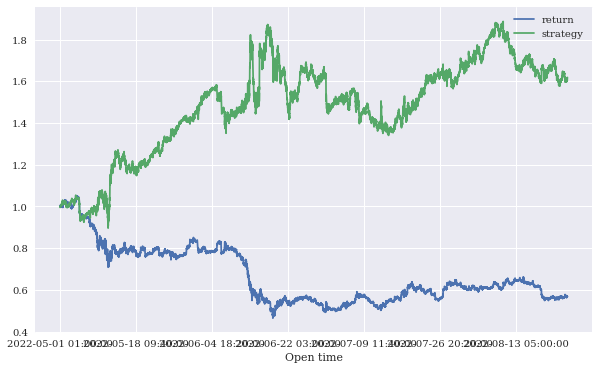

In [439]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

# lag=10, RSI, ADX, ADX_DIFFERENCE

## data

In [454]:
rsi = ta.momentum.RSIIndicator(df_5min['Open'], 14, False)
adx = ta.trend.ADXIndicator(df_5min['High'], df_5min['Low'], df_5min['Close'] , 20, False)

In [456]:
data = pd.DataFrame(df_5min['Close'])
data.rename(columns={'Close': 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
data['rsi'] = rsi.rsi()

data['adx'] = adx.adx()
data['adx_neg'] = adx.adx_neg()
data['adx_pos'] = adx.adx_pos()
data['adx_diff'] = data['adx_pos'] - data['adx_neg']

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [457]:
data[['adx', 'adx_neg', 'adx_pos', 'adx_diff']] = data[['adx', 'adx_neg', 'adx_pos', 'adx_diff']].shift(1)

In [458]:
lags = 10
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [459]:
cols.extend(['rsi', 'adx', 'adx_neg', 'adx_pos','adx_diff'])

In [460]:
print(data.round(4).tail())

                       price  return  direction      rsi      adx  adx_neg  \
Open time                                                                    
2022-08-25 00:40:00  21519.0 -0.0006          0  54.7645  14.8480  19.6171   
2022-08-25 00:45:00  21528.9  0.0005          1  52.2320  14.1616  20.8574   
2022-08-25 00:50:00  21512.8 -0.0007          0  54.1055  13.5830  20.9549   
2022-08-25 00:55:00  21528.9  0.0007          1  50.6605  13.1792  21.3966   
2022-08-25 01:00:00  21544.1  0.0007          1  53.8082  12.7956  20.8630   

                     adx_pos  adx_diff   lag_1   lag_2   lag_3   lag_4  \
Open time                                                                
2022-08-25 00:40:00  21.1066    1.4895 -0.0009  0.0018  0.0006 -0.0007   
2022-08-25 00:45:00  20.3950   -0.4624 -0.0006 -0.0009  0.0018  0.0006   
2022-08-25 00:50:00  19.8972   -1.0577  0.0005 -0.0006 -0.0009  0.0018   
2022-08-25 00:55:00  19.1630   -2.2336 -0.0007  0.0005 -0.0006 -0.0009   
2022-08-2

In [461]:
cutoff = '2022-05-01 01:00:00'

In [462]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy() 
test_data_ = (test_data - mu) / std

## model

In [463]:
optimizer = Adam(learning_rate=0.0001)

In [464]:
tf.random.set_seed(100)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [465]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

Wall time: 1min 34s


In [466]:
model.evaluate(training_data_[cols], training_data['direction'])

1080/1080 [==============================] - 3s 3ms/step - loss: 0.6844 - accuracy: 0.5545


[0.6843544840812683, 0.5545488595962524]

In [467]:
pred = model.predict(training_data_[cols])
training_data['prediction'] = np.where(pred > 0.5, 1, -1)
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']
training_data[['return', 'strategy']].sum().apply(np.exp)


return       0.805318
strategy    51.940938
dtype: float64

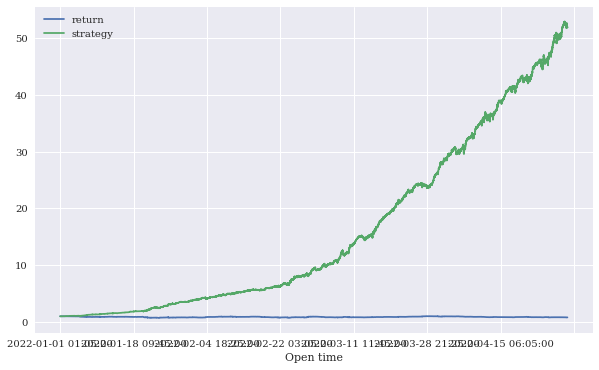

In [468]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

## test

In [469]:
model.evaluate(test_data_[cols], test_data['direction'])

1045/1045 [==============================] - 3s 3ms/step - loss: 0.6938 - accuracy: 0.5258


[0.6938121914863586, 0.5257864594459534]

In [470]:
pred = model.predict(test_data_[cols])
test_data['prediction'] = np.where(pred > 0.5, 1, -1)
test_data['prediction'].value_counts()
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.567996
strategy    3.135009
dtype: float64

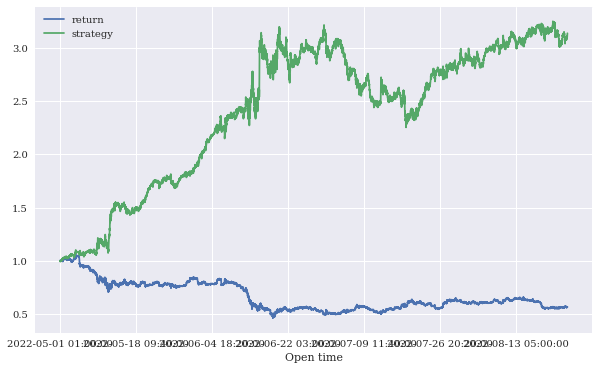

In [471]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

# RESULTS

for 5 min dataset works: lag=10, add rsi and ADX\
difference between adx neg and adx positive works but less stable\
treshholder works too\
Next step: CROSS-VALIDATION

# CROSS VALIDATION

## geting more data

In [440]:
api_key = 'KpcMqiJeSSgIc9nC4yk23PaWl6vlIeARyJB2EYe3cMAa8QbVjQ8b6RMNOMq1sUNN'
secret = 'SA4m55dzv4M6v02qEutAgn0qjxriDV4NnNzo9M59iZyshO6eUfcIk07udAZHWCd8'

In [441]:
from binance.futures import Futures as Client

In [442]:
futures_client = Client()

In [443]:
collumns2 = [
'Open time',
'Open',
'High',
'Low',
'Close',
'Volume',
'Close time',
'Quote asset volume',
'Number of trades',
'Taker buy base asset volume',
'Taker buy quote asset volume',
'Ignore'
]

In [444]:
def to_df(data_as_array):
    df=pd.DataFrame(data_as_array, columns = collumns2)
    df['Open time'] = df.apply(lambda x: datetime.fromtimestamp(int(x['Open time'])/1000) , axis=1)
    df['Close time'] = df.apply(lambda x: datetime.fromtimestamp(int(x['Close time'])/1000) , axis=1)
    df.drop(columns = ['Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], inplace = True)
    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype('float32', copy=False)
    return df

In [445]:
datetime_1 = int(datetime.timestamp(datetime.fromisoformat('2021-01-01 00:00:00'))*1000)
datetime_2 = int(datetime.timestamp(datetime.fromisoformat('2022-09-07 00:00:00'))*1000)

In [446]:
def make_df_BTC_5m(start_date, end_date, safe_df: bool = False, limit: int = 1000):
    """
    start_date, end_date - timestamp
    """
    df = pd.DataFrame(columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    num_of_tab_1 = int((end_date - start_date)/5/60/1000//limit)
    for i in range(num_of_tab_1+1):
        cur_startTime = int(i*1000*5*60*limit + start_date)
        data = futures_client.klines("BTCUSDT", "5m", **{"limit": limit, 'startTime': cur_startTime})
        df = pd.concat([df, to_df(data)], ignore_index = True)
        
    if safe_df == True:
        start_for_safe = str(datetime.fromtimestamp(start_date).year) + "_" + str(datetime.fromtimestamp(start_date).month)+ "_" + str(datetime.fromtimestamp(start_date).day)
        stop_for_safe = str(datetime.fromtimestamp(end_date).year) + "_" + str(datetime.fromtimestamp(end_date).month)+ "_" + str(datetime.fromtimestamp(end_date).day)
        df.to_csv('df_BTC_1h{}-{}.csv'.format(start_for_safe, stop_for_safe), index = False)
    return df

In [447]:
df_010121 = make_df_BTC_5m(datetime_1, datetime_2, False, limit = 1000)

In [449]:
df_010121.to_csv('5m_2021_2022.csv', index = False)

In [450]:
df_010121.index = df_010121['Open time']
df_010121 = df_010121.drop('Open time', axis = 1)

## data preparation functions

In [474]:
def get_prepared_data(df, cutoff:str = '2022-05-01 01:00:00', rsi_window:int = 14, adx_window:int = 20, lags:int = 10):
    '''
    this function takes dataset formated as: 
        index: 'Open time'
        columns: ['Open', 'High', 'Low', 'Close', 'Volume']
    calculates RSI and ADX
    returns 4 dataframes:
        training_data, 
        test_data, 
        training_data_ - normolized
        test_data_ - normolized
        cols - columns for training
    '''
    cols = []
    rsi = ta.momentum.RSIIndicator(df['Open'], rsi_window, False)
    adx = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'] , adx_window, False)
    
    data = pd.DataFrame(df['Close'])
    data.rename(columns={'Close': 'price'}, inplace=True)
    data['return'] = np.log(data['price'] /data['price'].shift(1))
    data['direction'] = np.where(data['return'] > 0, 1, 0)
    data['rsi'] = rsi.rsi()
    data['adx'] = adx.adx()
    data['adx_neg'] = adx.adx_neg()
    data['adx_pos'] = adx.adx_pos()
    data[['adx', 'adx_neg', 'adx_pos']] = data[['adx', 'adx_neg', 'adx_pos']].shift(1)
    
    for lag in range(1, lags + 1): # <5>
        col = f'lag_{lag}'
        data[col] = data['return'].shift(lag) # <6>
        cols.append(col)
        data.dropna(inplace=True) # <7>
    
    cols.extend(['rsi', 'adx', 'adx_neg', 'adx_pos'])
    
    training_data = data[data.index < cutoff].copy()
    mu, std = training_data.mean(), training_data.std()
    training_data_ = (training_data - mu) / std
    test_data = data[data.index >= cutoff].copy() 
    test_data_ = (test_data - mu) / std
    
    return training_data, test_data, training_data_, test_data_, cols

In [473]:
def get_model(input_shape, learning_rate=0.0001, dense_layer:int = 32):
    
    optimizer = Adam(learning_rate=learning_rate)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(dense_layer, activation='relu',input_shape=input_shape))
    model.add(Dense(dense_layer, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [476]:
def get_prediction(model, data_norm, data, cols):
    pred = model.predict(data_norm[cols])
    data['prediction'] = np.where(pred > 0.5, 1, -1)
    data['strategy'] = data['prediction'] * data['return']
    data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
    print(data[['return', 'strategy']].sum().apply(np.exp))

In [565]:
def get_prediction_2(model, data_norm, data, cols, plot = False):
    '''
    returns: anual_return, abs_return, max_drawdown
    
    '''
    pred = model.predict(data_norm[cols])
    data['prediction'] = np.where(pred > 0.5, 1, -1)
    data['strategy'] = data['prediction'] * data['return']
    data['cumret'] = data['strategy'].cumsum().apply(np.exp)
    data['cummax'] = data['cumret'].cummax()
    drawdown = data['cummax'] - data['cumret']
    max_drawdown = drawdown.max()
    abs_return = data[['return', 'strategy']].sum().apply(np.exp)['strategy']
    period = len(data)/105120
    anual_return = (abs_return-1)/period
    if plot==True:
        data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
    return anual_return, abs_return, max_drawdown

### test functions

In [477]:
training_data, test_data, training_data_, test_data_, cols = get_prepared_data(df_5min)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [480]:
model = get_model((len(cols),))

In [481]:
%%time 
model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)

Wall time: 1min 31s


In [482]:
model.evaluate(training_data_[cols], training_data['direction'])

1078/1078 [==============================] - 3s 2ms/step - loss: 0.6841 - accuracy: 0.5549


[0.6840851902961731, 0.5548952221870422]

return       0.811327
strategy    55.817826
dtype: float64


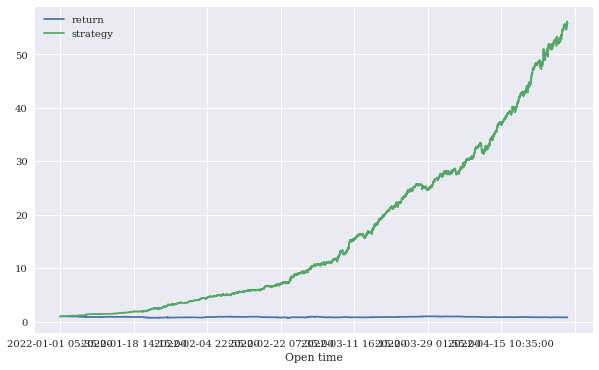

In [483]:
get_prediction(model, training_data_, training_data, cols)

return      0.567996
strategy    3.099122
dtype: float64


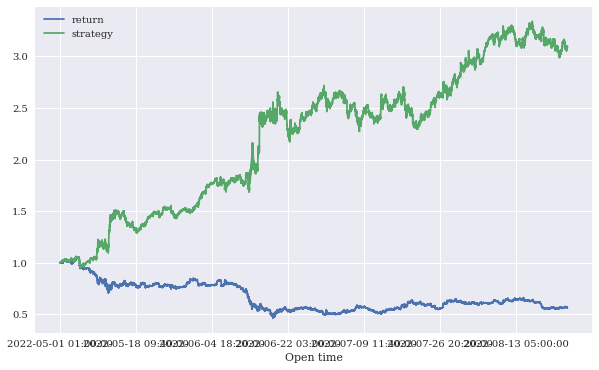

In [484]:
get_prediction(model, test_data_, test_data, cols)

## 5-fold folding

In [522]:
fold_lenght = len(df_010121)//5
test_lenght = fold_lenght//4

fold_1 = df_010121[fold_lenght*0 : fold_lenght*1]
fold_2 = df_010121[fold_lenght*1 : fold_lenght*2]
fold_3 = df_010121[fold_lenght*2 : fold_lenght*3]
fold_4 = df_010121[fold_lenght*3 : fold_lenght*4]
fold_5 = df_010121[fold_lenght*4 : fold_lenght*5]

cutoff_fold_1 = str(fold_1.iloc[-test_lenght].name)
cutoff_fold_2 = str(fold_2.iloc[-test_lenght].name)
cutoff_fold_3 = str(fold_3.iloc[-test_lenght].name)
cutoff_fold_4 = str(fold_4.iloc[-test_lenght].name)
cutoff_fold_5 = str(fold_5.iloc[-test_lenght].name)

### fold 1

In [529]:
training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_1, cutoff = cutoff_fold_1)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [532]:
model = get_model((len(cols),))

In [533]:
%%time 
model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)

Wall time: 1min 10s


return      0.943900
strategy    1.841819
dtype: float64


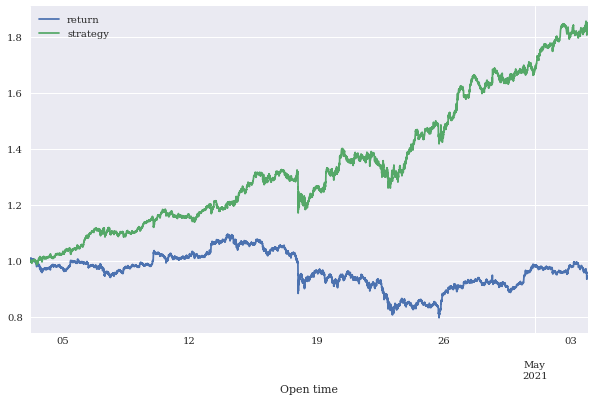

In [534]:
get_prediction(model, test_data_, test_data, cols)

### fold 2

In [535]:
training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_2, cutoff = cutoff_fold_2)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [536]:
model = get_model((len(cols),))

In [537]:
%%time 
model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)

Wall time: 1min 12s


return      1.320938
strategy    2.870885
dtype: float64


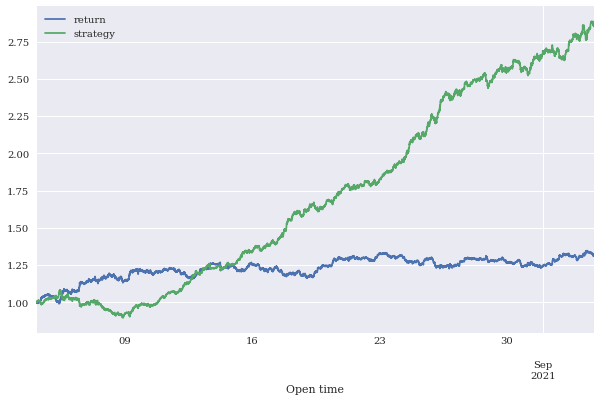

In [538]:
get_prediction(model, test_data_, test_data, cols)

### fold 3

In [539]:
training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_3, cutoff = cutoff_fold_3)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [540]:
model = get_model((len(cols),))

In [541]:
%%time 
model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)

Wall time: 1min 11s


return      0.944813
strategy    1.242439
dtype: float64


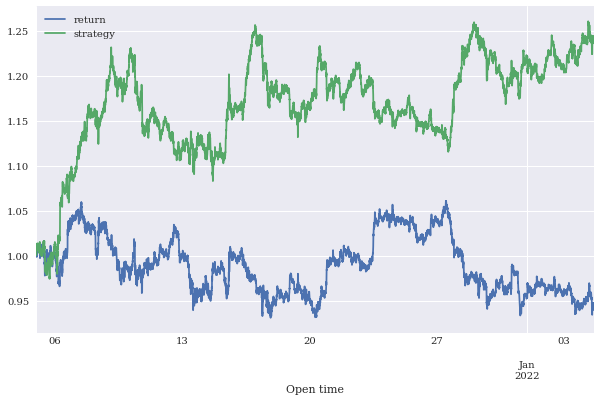

In [542]:
get_prediction(model, test_data_, test_data, cols)

### fold 4

In [543]:
training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_4, cutoff = cutoff_fold_4)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [544]:
model = get_model((len(cols),))

In [545]:
%%time 
model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)

Wall time: 1min 9s


return      0.829446
strategy    1.795292
dtype: float64


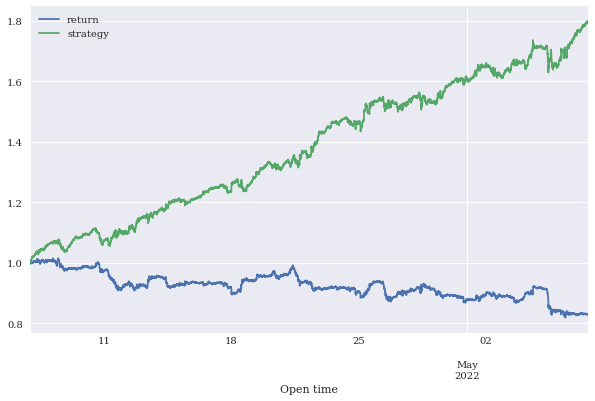

In [546]:
get_prediction(model, test_data_, test_data, cols)

### fold 5

In [547]:
training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_5, cutoff = cutoff_fold_5)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [548]:
model = get_model((len(cols),))

In [549]:
%%time 
model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)

Wall time: 1min 10s


return      0.815798
strategy    1.059915
dtype: float64


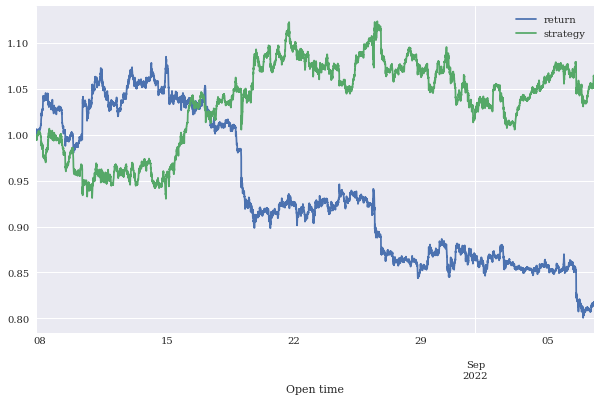

In [550]:
get_prediction(model, test_data_, test_data, cols)

## 10-fold folding, TEST PORTION = 4

In [574]:
df= df_010121.copy()
num_folds = 10
test_portion = 4

fold_lenght = len(df)//num_folds
test_lenght = fold_lenght//test_portion
fold_dfs = []
fold_cotoffs = []

for i in range(num_folds):
    temp_df = df[fold_lenght*i : fold_lenght*(i+1)]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

In [577]:
anual_returns = []
abs_returns = []
max_drawdowns = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

In [583]:
results=pd.DataFrame()
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results

,anual,abs,drawdown
0,15.330906,1.645205,0.144025
1,21.899406,1.921642,0.078422
2,13.045415,1.549019,0.157540
3,14.980660,1.630465,0.076473
4,3.134318,1.131909,0.146511
5,3.243574,1.136507,0.066404
6,-0.228743,0.990373,0.148749
7,3.755394,1.158047,0.100600
8,4.766306,1.200591,0.161808
9,0.991088,1.041710,0.103171


In [584]:
results.describe()

,anual,abs,drawdown
count,10.000000,10.000000,10.000000
mean,8.091832,1.340547,0.118370
std,7.547230,0.317627,0.037107
min,-0.228743,0.990373,0.066404
25%,3.161632,1.133058,0.083966
50%,4.260850,1.179319,0.123598
75%,14.496848,1.610103,0.148190
max,21.899406,1.921642,0.161808


## 10-fold folding, TEST PORTION = 5

In [585]:
df= df_010121.copy()
num_folds = 10
test_portion = 5

fold_lenght = len(df)//num_folds
test_lenght = fold_lenght//test_portion
fold_dfs = []
fold_cotoffs = []

for i in range(num_folds):
    temp_df = df[fold_lenght*i : fold_lenght*(i+1)]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

In [586]:
anual_returns = []
abs_returns = []
max_drawdowns = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

In [587]:
results=pd.DataFrame()
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results

,anual,abs,drawdown
0,8.696751,1.292787,0.149766
1,16.450320,1.553821,0.091269
2,20.984949,1.706485,0.131788
3,15.881386,1.534667,0.080722
4,0.740518,1.024930,0.117639
5,3.858351,1.129896,0.059258
6,-0.328250,0.988949,0.125391
7,2.862283,1.096362,0.098409
8,2.625817,1.088402,0.139756
9,-0.329971,0.988891,0.085005


In [588]:
results.describe()

,anual,abs,drawdown
count,10.000000,10.000000,10.000000
mean,7.144216,1.240519,0.107900
std,7.882289,0.265367,0.029315
min,-0.329971,0.988891,0.059258
25%,1.211842,1.040798,0.086571
50%,3.360317,1.113129,0.108024
75%,14.085227,1.474197,0.130189
max,20.984949,1.706485,0.149766


## 5-fold folding, TEST PORTION = 10

In [589]:
df= df_010121.copy()
num_folds = 5
test_portion = 10

fold_lenght = len(df)//num_folds
test_lenght = fold_lenght//test_portion
fold_dfs = []
fold_cotoffs = []

for i in range(num_folds):
    temp_df = df[fold_lenght*i : fold_lenght*(i+1)]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

In [590]:
anual_returns = []
abs_returns = []
max_drawdowns = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

In [591]:
results=pd.DataFrame()
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results

,anual,abs,drawdown
0,12.168904,1.409682,0.076760
1,16.266474,1.547632,0.086052
2,-0.474027,0.984041,0.086977
3,2.501310,1.084210,0.108762
4,-0.038901,0.998690,0.071779


In [592]:
results.describe()

,anual,abs,drawdown
count,5.000000,5.000000,5.000000
mean,6.084752,1.204851,0.086066
std,7.649218,0.257521,0.014201
min,-0.474027,0.984041,0.071779
25%,-0.038901,0.998690,0.076760
50%,2.501310,1.084210,0.086052
75%,12.168904,1.409682,0.086977
max,16.266474,1.547632,0.108762


# Shifting Foiding

lenghts of 5 min df\
105120 - 1 year\
8760 - 1 month\
2190 - week\
312 - day

## 4 month/1 week

In [629]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*4
test_lenght = 2190
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 112 days
test period: 7 days
step: 22 days


In [630]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## 3 month/1 week

In [612]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*3
test_lenght = 2190
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 84 days
test period: 7 days
step: 24 days


In [614]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

,date,anual,abs,drawdown
0,2021-04-02 07:00:00,7.768776,1.161850,0.028739
1,2021-04-28 01:45:00,10.999580,1.229158,0.035394
2,2021-05-23 20:30:00,88.458349,2.842882,0.171202
3,2021-06-18 15:15:00,9.794820,1.204059,0.124212
4,2021-07-14 10:00:00,18.762655,1.390889,0.059035
5,2021-08-09 04:45:00,23.584368,1.491341,0.040730
6,2021-09-03 23:30:00,2.552739,1.053182,0.156567
7,2021-09-29 18:15:00,3.326146,1.069295,0.121176
8,2021-10-25 13:00:00,3.489389,1.072696,0.123517
9,2021-11-20 06:45:00,11.028794,1.229767,0.077787


In [619]:
results.describe()

,anual,abs,drawdown
count,20.000000,20.000000,20.000000
mean,10.517550,1.219116,0.091689
std,19.373788,0.403621,0.048022
min,-1.814247,0.962203,0.028739
25%,2.509016,1.052271,0.053957
50%,5.141470,1.107114,0.073491
75%,10.096010,1.210334,0.124614
max,88.458349,2.842882,0.183619


<AxesSubplot:>

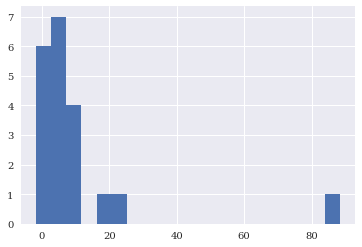

In [622]:
results.anual.hist(bins=20)

<AxesSubplot:>

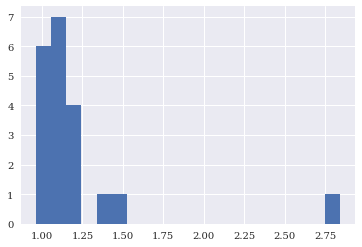

In [626]:
results['abs'].hist(bins=20)

<AxesSubplot:>

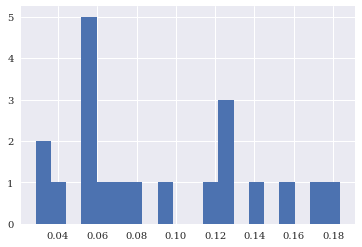

In [627]:
results['drawdown'].hist(bins=20)

## 2 month/1 week

In [631]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*2
test_lenght = 2190
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 56 days
test period: 7 days
step: 25 days


In [632]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## 1 month/1 week

In [633]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*1
test_lenght = 2190
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 28 days
test period: 7 days
step: 27 days


In [634]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## 4 month/2 week

In [635]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*4
test_lenght = 2190*2
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 112 days
test period: 14 days
step: 22 days


In [636]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## 3 month/2 week

In [637]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*3
test_lenght = 2190*2
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 84 days
test period: 14 days
step: 23 days


In [638]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## 2 month/2 week

In [639]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*2
test_lenght = 2190*2
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 56 days
test period: 14 days
step: 25 days


In [640]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## 4 month/3 week

In [641]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*4
test_lenght = 2190*3
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 112 days
test period: 21 days
step: 22 days


In [642]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## 3 month/3 week

In [643]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*3
test_lenght = 2190*3
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 84 days
test period: 21 days
step: 23 days


In [644]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## 2 month/3 week

In [645]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*2
test_lenght = 2190*3
num_folds = 20

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 56 days
test period: 21 days
step: 24 days


In [646]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

## Result

In [647]:
df_112_7 = pd.read_csv('results_NN_112_days_train_7_days_test.csv')
df_84_7 = pd.read_csv('results_NN_84_days_train_7_days_test.csv')
df_56_7 = pd.read_csv('results_NN_56_days_train_7_days_test.csv')
df_28_7 = pd.read_csv('results_NN_28_days_train_7_days_test.csv')
df_112_14 = pd.read_csv('results_NN_112_days_train_14_days_test.csv')
df_84_14 = pd.read_csv('results_NN_84_days_train_14_days_test.csv')
df_56_14 = pd.read_csv('results_NN_56_days_train_14_days_test.csv')
df_112_21 = pd.read_csv('results_NN_112_days_train_21_days_test.csv')
df_84_21 = pd.read_csv('results_NN_84_days_train_21_days_test.csv')
df_56_21 = pd.read_csv('results_NN_56_days_train_21_days_test.csv')

In [652]:
df_112_7.head()

,date,anual,abs,drawdown
0,2021-05-02 17:00:00,12.450131,1.259378,0.059919
1,2021-05-26 23:15:00,51.094131,2.064461,0.123429
2,2021-06-20 05:30:00,13.033987,1.271541,0.143097
3,2021-07-14 11:45:00,16.877107,1.351606,0.055354
4,2021-08-07 18:00:00,13.289101,1.276856,0.061837


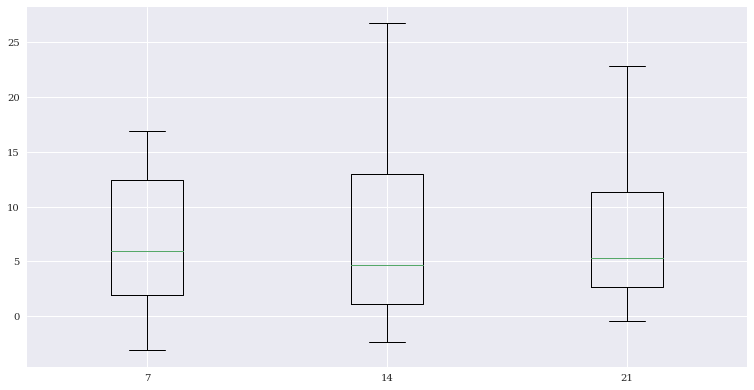

In [664]:
data_1 = df_112_7['anual']
data_2 = df_112_14['anual']
data_3 = df_112_21['anual']
labels = ['7', '14', '21'] 
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

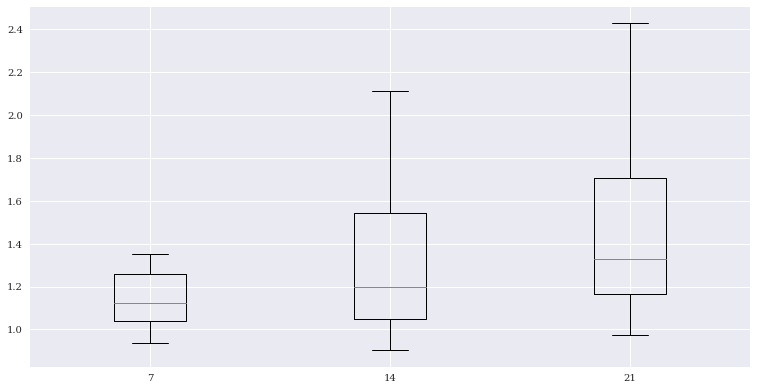

In [663]:
data_1 = df_112_7['abs']
data_2 = df_112_14['abs']
data_3 = df_112_21['abs']
labels = ['7', '14', '21'] 
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

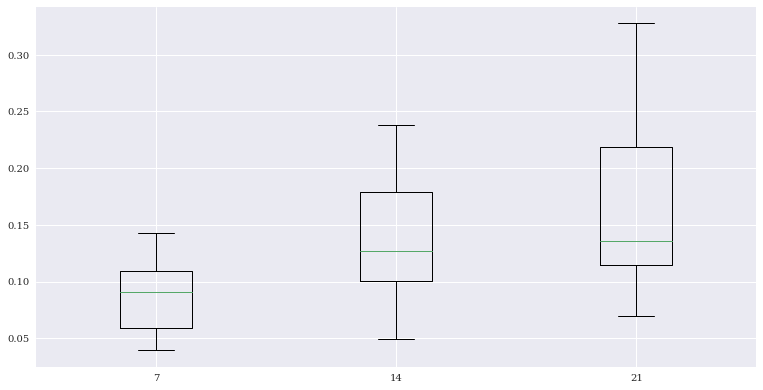

In [662]:
data_1 = df_112_7['drawdown']
data_2 = df_112_14['drawdown']
data_3 = df_112_21['drawdown']
labels = ['7', '14', '21'] 
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

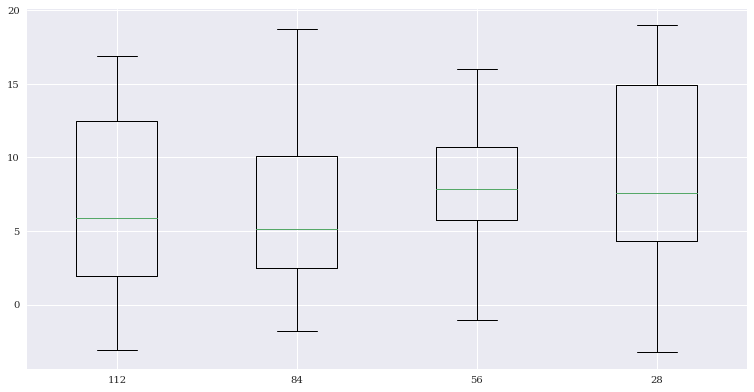

In [661]:
data_1 = df_112_7['anual']
data_2 = df_84_7['anual']
data_3 = df_56_7['anual']
data_4 = df_28_7['anual']

labels = ['112', '84', '56', '28'] 
data = [data_1, data_2, data_3, data_4]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

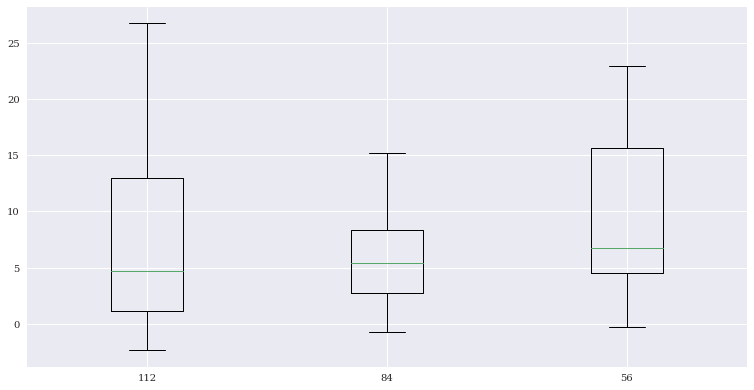

In [665]:
data_1 = df_112_14['anual']
data_2 = df_84_14['anual']
data_3 = df_56_14['anual']

labels = ['112', '84', '56'] 
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

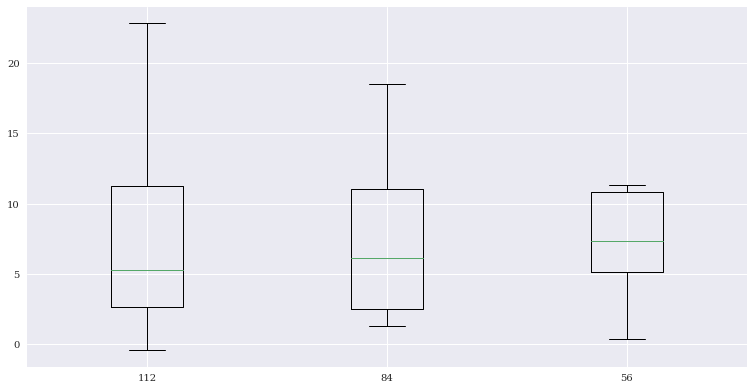

In [666]:
data_1 = df_112_21['anual']
data_2 = df_84_21['anual']
data_3 = df_56_21['anual']

labels = ['112', '84', '56'] 
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

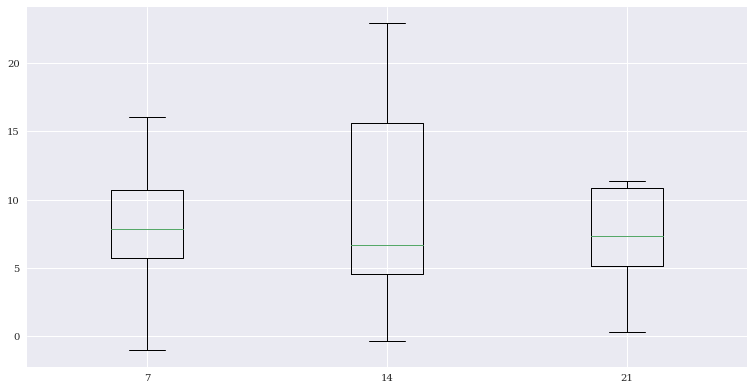

In [669]:
data_1 = df_56_7['anual']
data_2 = df_56_14['anual']
data_3 = df_56_21['anual']
labels = ['7', '14', '21'] 
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

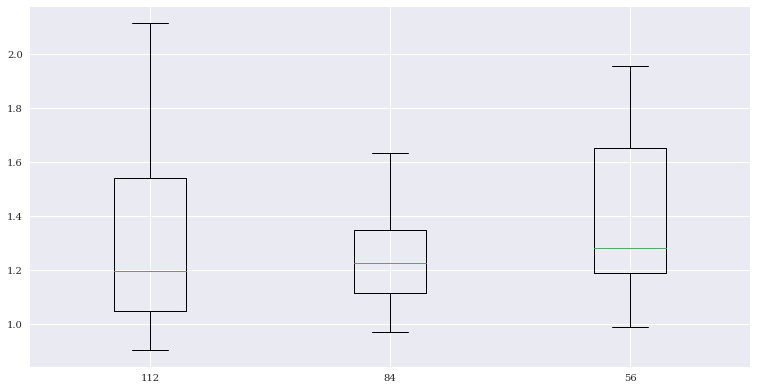

In [671]:
data_1 = df_112_14['abs']
data_2 = df_84_14['abs']
data_3 = df_56_14['abs']

labels = ['112', '84', '56'] 
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

# Conclusion

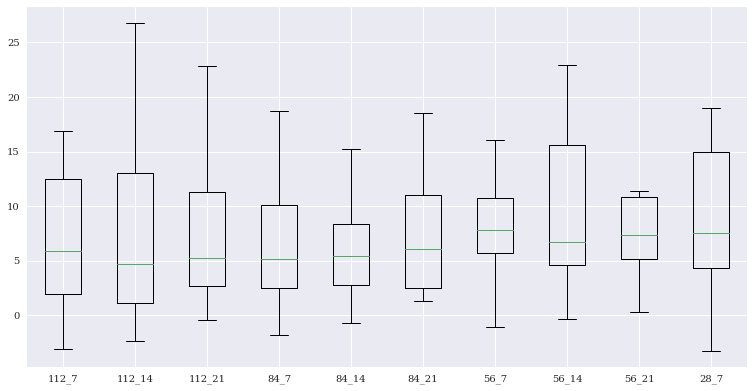

In [670]:
data_1 = df_112_7['anual']
data_2 = df_112_14['anual']
data_3 = df_112_21['anual']

data_4 = df_84_7['anual']
data_5 = df_84_14['anual']
data_6 = df_84_21['anual']

data_7 = df_56_7['anual']
data_8 = df_56_14['anual']
data_9 = df_56_21['anual']

data_0 = df_28_7['anual']



labels = ['112_7', '112_14', '112_21', '84_7', '84_14', '84_21','56_7', '56_14', '56_21','28_7', ] 
data = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_0]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

In [673]:
df_56_14.describe()

,anual,abs,drawdown
count,20.000000,20.000000,20.000000
mean,11.098023,1.462418,0.119220
std,12.141829,0.505910,0.062006
min,-0.315575,0.986851,0.058875
25%,4.568667,1.190361,0.075232
50%,6.708191,1.279508,0.102723
75%,15.613651,1.650569,0.144464
max,54.583037,3.274293,0.312490


In [675]:
df_56_14

,date,anual,abs,drawdown
0,2021-03-02 20:00:00,16.088894,1.670371,0.143555
1,2021-03-29 19:10:00,4.767430,1.198643,0.073024
2,2021-04-25 17:20:00,19.601544,1.816731,0.075968
3,2021-05-22 15:30:00,54.583037,3.274293,0.312490
4,2021-06-18 13:40:00,15.455237,1.643968,0.161518
5,2021-07-15 11:50:00,9.350958,1.389623,0.192434
6,2021-08-11 10:00:00,22.931607,1.955484,0.082909
7,2021-09-07 08:10:00,4.865297,1.202721,0.147192
8,2021-10-04 06:20:00,-0.315575,0.986851,0.118534
9,2021-10-31 04:30:00,6.671671,1.277986,0.077065


It seems that 56 day for training with prediction for 2 weeks is optimal\
Ley's check more detailed calculation. 

In [685]:
df= df_010121.copy()
#set parameters
train_lenght = 8760*2
test_lenght = 2190*2
num_folds = 34

df_lenght = len(df)
fold_dfs = []
fold_cotoffs = []

step = (df_lenght - train_lenght - test_lenght)//num_folds
print(f'traine period: {round(train_lenght/312)} days')
print(f'test period: {round(test_lenght/312)} days')
print(f'step: {round(step/312)} days')

for i in range(num_folds):
    temp_df = df[step*i:(train_lenght+test_lenght)+step*i]
    fold_dfs.append(temp_df)
    fold_cotoffs.append(str(temp_df.iloc[-test_lenght].name))

traine period: 56 days
test period: 14 days
step: 15 days


In [686]:
anual_returns = []
abs_returns = []
max_drawdowns = []
cutoffs = []

for i in range(num_folds):
    training_data, test_data, training_data_, test_data_, cols = get_prepared_data(fold_dfs[i], cutoff = fold_cotoffs[i])
    model = get_model((len(cols),))
    model.fit(training_data_[cols], training_data['direction'],verbose=False, epochs=25)
    anual_return, abs_return, max_drawdown = get_prediction_2(model, test_data_, test_data, cols)
    
    anual_returns.append(anual_return)
    abs_returns.append(abs_return)
    max_drawdowns.append(max_drawdown)

results=pd.DataFrame()
results['date'] = fold_cotoffs
results['anual']=anual_returns
results['abs']=abs_returns
results['drawdown']=max_drawdowns
results
results.to_csv(f'results_NN_{round(train_lenght/312)}_days_train_{round(test_lenght/312)}_days_test.csv', index= False)

C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\bakhi\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\bakhi\a

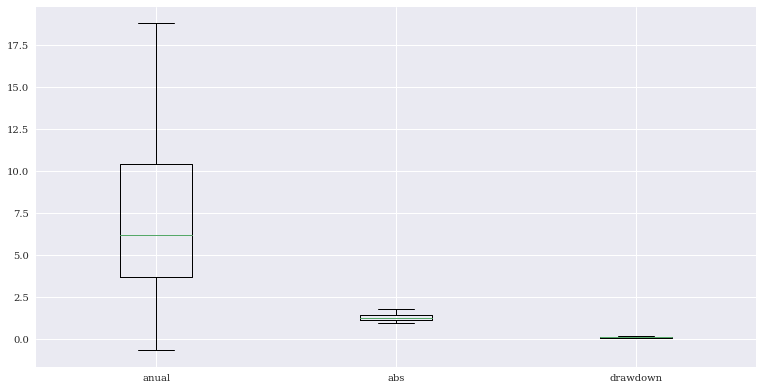

In [690]:
data_1 = results['anual']
data_2 = results['abs']
data_3 = results['drawdown']

labels = ['anual', 'abs', 'drawdown'] 
data = [data_1, data_2, data_3]

fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels = labels, showfliers = False)
plt.show()

In [691]:
results.describe()

,anual,abs,drawdown
count,34.000000,34.000000,34.000000
mean,10.902385,1.454266,0.141755
std,13.760021,0.573334,0.128317
min,-0.680949,0.971627,0.043111
25%,3.687850,1.153660,0.078813
50%,6.180985,1.257541,0.114395
75%,10.390649,1.432944,0.146105
max,64.479823,3.686659,0.745599
